In [1]:
%matplotlib inline

# Offline portion

I manually ran fastANI on the set of phage genomes (`.fasta` files) for each host.

For example:
```
find ../Data/MVP_DB/562_rep_viruses/*.fasta -type f> file_listing.txt

fastANI --ql file_listing.txt --rl file_listing.txt --fragLen 300 --minFraction 0.8 -o 562_ANI.output
```

To run for all hosts, just replace both instances of `562` in the above code. Didn't seem worth writing a bash script for. 

In [2]:
import pandas as pd
import glob
from Bio import SeqIO

In [3]:
taxon_id = '562'
input_df = pd.read_csv('../Data/MVP_data/fastANI_results/{}_ANI.output'.format(taxon_id), sep='\t', header=None)
print('Shape:', input_df.shape)
print('Non-null shape:', input_df[input_df[2].isnull()==False].shape)
input_df.head()

Shape: (1141, 5)
Non-null shape: (1141, 5)


,0,1,2,3,4
0,../Data/MVP_DB/562_rep_viruses/10044.fasta,../Data/MVP_DB/562_rep_viruses/10044.fasta,100.0000,117,120
1,../Data/MVP_DB/562_rep_viruses/10111.fasta,../Data/MVP_DB/562_rep_viruses/10111.fasta,100.0000,120,120
2,../Data/MVP_DB/562_rep_viruses/10111.fasta,../Data/MVP_DB/562_rep_viruses/11438.fasta,95.8651,94,120
3,../Data/MVP_DB/562_rep_viruses/10111.fasta,../Data/MVP_DB/562_rep_viruses/11884.fasta,94.9761,88,120
4,../Data/MVP_DB/562_rep_viruses/10111.fasta,../Data/MVP_DB/562_rep_viruses/7139.fasta,94.9603,99,120


In [4]:
input_df['temp'] = input_df[0].str.split("/").str[-1]
input_df['query_seq'] = input_df['temp'].str.split('.').str[0]
input_df['temp'] = input_df[1].str.split("/").str[-1]
input_df['ref_seq'] = input_df['temp'].str.split('.').str[0]
input_df = input_df[['query_seq', 'ref_seq', 2, 3, 4]]
print(input_df[input_df[2]==100.].shape)
input_df = input_df[input_df['query_seq'] != input_df['ref_seq']]
print(input_df.shape)
input_df.head(n=20)

(365, 5)
(769, 5)


,query_seq,ref_seq,2,3,4
2,10111,11438,95.8651,94,120
3,10111,11884,94.9761,88,120
4,10111,7139,94.9603,99,120
6,10203,9032,96.6925,99,119
7,10203,8248,96.6038,96,119
8,10203,1758,96.4027,100,119
11,1025,652,97.6557,212,248
12,1025,614,97.3440,216,248
13,1025,229,97.2761,201,248
14,1025,2462,96.8932,148,248


# Re-create the cd-hit-est algorithm for clustering

There's probably a faster way to do this but it seemed straightforward enough to quickly write up the greedy incremental clustering approach.

In [5]:
records = []
for infile in glob.glob('../Data/MVP_data/host_linked_genomes/{}_rep_viruses/*.fasta'.format(taxon_id)):
    tempy = SeqIO.read(infile, 'fasta')
    records.append((infile.split('/')[-1].split('.')[0], len(tempy.seq)))
records = sorted(records, key=lambda x: x[1], reverse=True) ###Critical step!
print('First, last record sequence length:', records[0][1], ',', records[-1][1])
print('Total sequences:', len(records))
len_dict = dict(records) #useful for sorting later

First, last record sequence length: 176788 , 20317
Total sequences: 374


In [11]:
input_df_copy = input_df.copy(deep=True)
thresh = 80
clusters = []
found = []
for record in records: 
    ### Records must be sorted in order! (see above)
    if record[0] in found:
        continue
    ###Find all instances of this record in the dataframe
    temp_df = input_df_copy[(input_df_copy['query_seq']==record[0]) | (input_df_copy['ref_seq']==record[0])]
    ###Select all cases where the identity is greater than the specified threshold
    temp_df = temp_df[temp_df[2] > thresh]
    
    ###Two paths!
    ###If there are some cases
    if temp_df.shape[0] != 0:
        ###Find everyone involved
        all_seqs = list(set(list(temp_df['query_seq'])+list(temp_df['ref_seq'])))        
        ###Move my sequence (the longest) to the front of the list
        all_seqs.insert(0, all_seqs.pop(all_seqs.index(record[0])))
        
        ###Loop through everyone else
        stop = False
        while stop == False:
            current_len = len(all_seqs)
            added = 1
            for seq_id in all_seqs[added:]:
                ###Find all instances of this record in the dataframe
                temp_df = input_df_copy[(input_df_copy['query_seq']==seq_id) | (input_df_copy['ref_seq']==seq_id)]
                ###Select all cases where the identity is greater than the specified threshold
                temp_df = temp_df[temp_df[2] > thresh]
                if temp_df.shape[0] != 0:
                    ###Find everyone involved
                    all_seqs_rd2 = list(set(list(temp_df['query_seq'])+list(temp_df['ref_seq'])))        
                    for new_seq in all_seqs_rd2:
                        if new_seq not in all_seqs:
                            all_seqs.append(new_seq)
                added += 1
            final_len = len(all_seqs)
            if final_len == current_len:
                stop = True
        ###Finally, call it a cluster
        clusters.append(all_seqs)
        ###Note that everyone in the cluster is accounted for and should be skipped
        found.extend(all_seqs)
        ###Remove everyone that I found from the temporary dataframe
        input_df_copy = input_df_copy[input_df_copy['query_seq'].isin(all_seqs)==False]
        input_df_copy = input_df_copy[input_df_copy['ref_seq'].isin(all_seqs)==False]
    ###If the sequence is a beautiful little snowflake
    else:
        ###It's a unique cluster of one
        clusters.append([record[0]])
        ###That has been found, though it found no one
        found.append(record[0])
        ###Remove everyone that I found from the temporary dataframe
        input_df_copy = input_df_copy[input_df_copy['query_seq']!= record[0]]
        input_df_copy = input_df_copy[input_df_copy['ref_seq']!= record[0]]
for i, j in enumerate(clusters):
    clusters[i] = sorted(j, key=lambda x: len_dict[x], reverse=True)
    
print(len(clusters), sum([len(i) for i in clusters]))

178 374


# Write to file

In [12]:
with open('../Data/MVP_data/host_linked_genomes/{}_independent.txt'.format(taxon_id), 'w') as outfile:
    for cluster in clusters:
        outfile.write('{}\n'.format(cluster[0]))

# Visualize what those results look like

In [13]:
input_df = pd.read_csv('../Data/MVP_data/fastANI_results/{}_ANI.output'.format(taxon_id), sep='\t', header=None)
print('Shape:', input_df.shape)
print('Non-null shape:', input_df[input_df[2].isnull()==False].shape)
input_df['temp'] = input_df[0].str.split("/").str[-1]
input_df['query_seq'] = input_df['temp'].str.split('.').str[0]
input_df['temp'] = input_df[1].str.split("/").str[-1]
input_df['ref_seq'] = input_df['temp'].str.split('.').str[0]
input_df = input_df[['query_seq', 'ref_seq', 2, 3, 4]]
print(input_df.shape)

sim_df = input_df.pivot(index='query_seq', columns='ref_seq', values=2)
sim_matrix = sim_df.values

Shape: (1141, 5)
Non-null shape: (1141, 5)
(1141, 5)


In [14]:
temp = [str(item) for sublist in clusters for item in sublist if item in sim_df.index]
ordered_sim_matrix = sim_df.loc[temp][temp].values

In [15]:
print(len(sim_df.index), len(sim_df.index))

372 372


In [16]:
from matplotlib import pyplot as plt

Text(0.5, 1.05, 'After greedy algorithm')

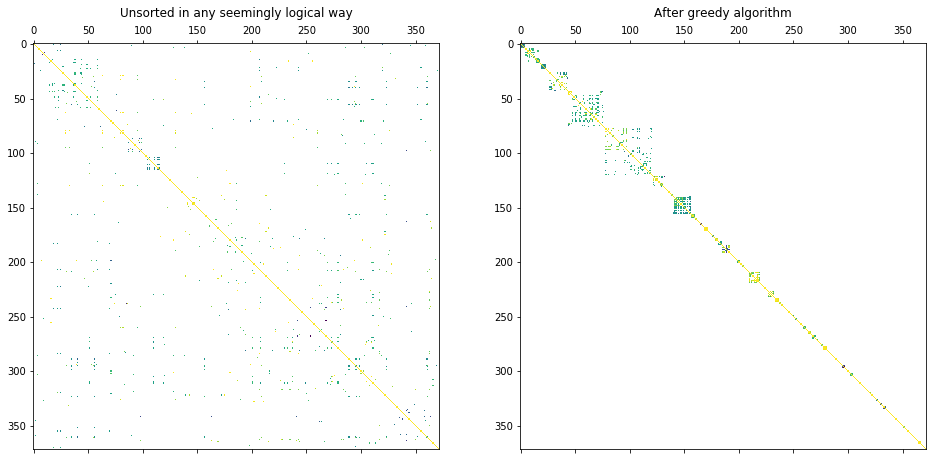

In [18]:
fig, ax_arr = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
ax_arr[0].matshow(sim_matrix)
ax_arr[0].set_title('Unsorted in any seemingly logical way')
ax_arr[1].matshow(ordered_sim_matrix)
ax_arr[1].set_title('After greedy algorithm')